In [54]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
from pathlib import Path 
import pandas as pd
import copy
from scipy.sparse import csr_matrix

plt.rcParams['figure.figsize'] = (4, 3) 

## Read AnnData

In [5]:
# path_scrnaseq = "/lustre/groups/ml01/workspace/alessandro.palma/scportrait/data/scrnaseq/sce_converted.h5ad"
path_scrnaseq = "/nfs/homedirs/pala/scportrait_ot/project_folder/data/scrnaseq/sce_converted.h5ad"
adata = sc.read_h5ad(path_scrnaseq)

In [6]:
adata

AnnData object with n_obs × n_vars = 462352 × 37378
    obs: 'barcode', 'donor_id', 'gem_id', 'library_name', 'assay', 'sex', 'age', 'age_group', 'hospital', 'cohort_type', 'cause_for_tonsillectomy', 'is_hashed', 'preservation', 'nCount_RNA', 'nFeature_RNA', 'pct_mt', 'pct_ribosomal', 'pDNN_hashing', 'pDNN_scrublet', 'pDNN_union', 'scrublet_doublet_scores', 'S.Score', 'G2M.Score', 'Phase', 'scrublet_predicted_doublet', 'doublet_score_scDblFinder', 'annotation_level_1', 'annotation_level_1_probability', 'annotation_figure_1', 'annotation_20220215', 'annotation_20220619', 'annotation_20230508', 'annotation_20230508_probability', 'UMAP_1_level_1', 'UMAP_2_level_1', 'UMAP_1_20220215', 'UMAP_2_20220215', 'UMAP_1_20230508', 'UMAP_2_20230508', 'type'
    var: 'gene_name', 'highly_variable', 'gene_id'
    uns: 'X_name'
    obsm: 'HARMONY', 'PCA', 'UMAP'
    layers: 'logcounts'

## Collect genes to keep 

In [7]:
# Read the codex to RNA
# codex_matching_ensembl = pd.read_csv("/lustre/groups/ml01/workspace/alessandro.palma/scportrait/data/codex/codex_matching_ensembl.tsv", sep="\t")# codex_matching_ensembl = pd.read_csv("/lustre/groups/ml01/workspace/alessandro.palma/scportrait/data/codex/codex_matching_ensembl.tsv", sep="\t")
codex_matching_ensembl = pd.read_csv("/nfs/homedirs/pala/scportrait_ot/project_folder/data/codex_matching_ensembl.tsv", sep="\t")
codex_matching_ensembl.shape

(59, 6)

Remove NaNs 

In [8]:
codex_matching_ensembl = codex_matching_ensembl[codex_matching_ensembl['gene_ids_present_in_dataset'].notna()]
codex_matching_ensembl

,Codex_Name,gene_id,gene_ids_present_in_dataset,HGNC_ID,Comment,Unnamed: 5
1,HLA-DR,NaN,"ENSG00000204287,ENSG00000198502,ENSG00000196126",4947.0,"HLA-DRA, HLA-DRB5,HLA-DRB1 were found in the g...",NaN
2,S100,Multiple,ENSG00000196154,NaN,Based on an alternative study published by the...,NaN
3,MCT,Multiple,ENSG00000232119,NaN,"MCT family is quite large, unclear which prote...",NaN
5,CD45,"ENSG00000262418,ENSG00000081237",ENSG00000081237,9666.0,Only one of the transcript ids found in dataset,NaN
8,CD8,"ENSG00000153563,ENSG00000172116","ENSG00000153563,ENSG00000172116",NaN,CD8A and CD8B,NaN
9,CD3,"ENSG00000198851,ENSG00000160654,ENSG00000167286","ENSG00000198851,ENSG00000160654,ENSG00000167286",NaN,"CD3E, CD3D, and CD3G",NaN
10,CD16,"ENSG00000203747,ENSG00000162747","ENSG00000203747,ENSG00000162747",NaN,"CD16a, CD16b",NaN
11,CollagenIV,"ENSG00000187498,ENSG00000134871,ENSG0000016903...","ENSG00000187498,ENSG00000134871,ENSG0000016903...",NaN,"COL4A1, COL4A2, COL4A3, COL4A4, COL4A5, COL4A6",NaN
12,CHGA,"ENSG00000276781,ENSG00000100604",ENSG00000100604,NaN,Only one of the transcript ids found in dataset,NaN
13,PD-1,"ENSG00000188389,ENSG00000276977",ENSG00000188389,NaN,Only one of the transcript ids found in dataset,NaN


## Unique genes 

In [9]:
# Initialize matrix of counts and logcounts 
expression_matrx = np.zeros((adata.shape[0], codex_matching_ensembl.shape[0]))
expression_matrx_counts = np.zeros((adata.shape[0], codex_matching_ensembl.shape[0]))

gene_columns = []

for i, gene in enumerate(codex_matching_ensembl.gene_ids_present_in_dataset):
    gene_split = gene.split(",")
    
    if len(gene_split)==1:
        expression_matrx[:, i] = adata[:, adata.var["gene_id"]==gene].layers["logcounts"].squeeze().copy()
        expression_matrx_counts[:, i] = adata[:, adata.var["gene_id"]==gene].X.squeeze().copy()
    else:
        expression_matrx[:, i] = adata[:, adata.var["gene_id"].isin(gene_split)].layers["logcounts"].max(1).copy()
        expression_matrx_counts[:, i] = adata[:, adata.var["gene_id"].isin(gene_split)].X.max(1).copy()
    # Save gene column names
    gene_columns.append(gene)

In [10]:
expression_matrx

array([[2.87997273, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [5.13941058, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.2890183 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 1.48692787, 1.48692787, ..., 0.        , 0.        ,
        0.        ],
       [2.06775241, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.55455256, 0.80840382, 0.48375945, ..., 0.        , 0.        ,
        0.        ]], shape=(462352, 55))

In [11]:
expression_matrx_counts

array([[  4.,   0.,   0., ...,   0.,   0.,   0.],
       [186.,   0.,   0., ...,   0.,   0.,   0.],
       [  1.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   1.,   1., ...,   0.,   0.,   0.],
       [  5.,   0.,   0., ...,   0.,   0.,   0.],
       [  6.,   2.,   1., ...,   0.,   0.,   0.]], shape=(462352, 55))

In [12]:
adata_reduced = sc.AnnData(X=expression_matrx, obs=adata.obs)
adata_reduced.var.index= gene_columns
adata_reduced.obsm = adata.obsm
adata_reduced.layers["X_counts"] = expression_matrx_counts

Save anndata object separately for all and discovery

In [13]:
np.unique(adata_reduced.obs.cohort_type, return_counts=True)

(array(['discovery', 'validation'], dtype=object), array([263286, 199066]))

In [14]:
# adata_reduced.write_h5ad("/lustre/groups/ml01/workspace/alessandro.palma/scportrait/data/scrnaseq/sce_converted_processed_total.h5ad")
# adata_reduced[adata_reduced.obs.cohort_type=='discovery'].write_h5ad("/lustre/groups/ml01/workspace/alessandro.palma/scportrait/data/scrnaseq/sce_converted_processed_discovery.h5ad")

In [15]:
adata_reduced.write_h5ad("/nfs/homedirs/pala/scportrait_ot/project_folder/data/scrnaseq/sce_converted_processed_total.h5ad")
adata_reduced[adata_reduced.obs.cohort_type=='discovery'].write_h5ad("/nfs/homedirs/pala/scportrait_ot/project_folder/data/scrnaseq/sce_converted_processed_discovery.h5ad")

In [16]:
del adata_reduced

# Highly variable genes 

In [25]:
adata_hvg = adata[adata.obs.cohort_type=="discovery", adata.var.highly_variable]

In [26]:
# del adata_hvg.obsm["HARMONY"]
del adata_hvg.layers["logcounts"]

/tmp/ipykernel_3788104/3379804169.py:2: ImplicitModificationWarning: Removing element `.layers['logcounts']` of view, initializing view as actual.
  del adata_hvg.layers["logcounts"]


In [27]:
adata_hvg.write_h5ad("/nfs/homedirs/pala/scportrait_ot/project_folder/data/scrnaseq/sce_converted_processed_discovery_hvgs.h5ad")

In [28]:
del adata_hvg

# All genes memory friendly

In [32]:
del adata.layers["logcounts"]

In [34]:
adata = adata[adata.obs.cohort_type=="discovery"]

In [41]:
adata.obs.columns

Index(['barcode', 'donor_id', 'gem_id', 'library_name', 'assay', 'sex', 'age',
       'age_group', 'hospital', 'cohort_type', 'cause_for_tonsillectomy',
       'is_hashed', 'preservation', 'nCount_RNA', 'nFeature_RNA', 'pct_mt',
       'pct_ribosomal', 'pDNN_hashing', 'pDNN_scrublet', 'pDNN_union',
       'scrublet_doublet_scores', 'S.Score', 'G2M.Score', 'Phase',
       'scrublet_predicted_doublet', 'doublet_score_scDblFinder',
       'annotation_level_1', 'annotation_level_1_probability',
       'annotation_figure_1', 'annotation_20220215', 'annotation_20220619',
       'annotation_20230508', 'annotation_20230508_probability',
       'UMAP_1_level_1', 'UMAP_2_level_1', 'UMAP_1_20220215',
       'UMAP_2_20220215', 'UMAP_1_20230508', 'UMAP_2_20230508', 'type'],
      dtype='object')

In [43]:
adata.obs = adata.obs.loc[:, ["donor_id", "annotation_level_1"]]

In [55]:
adata.X = csr_matrix(adata.X)

In [57]:
# adata.write_h5ad("/nfs/homedirs/pala/scportrait_ot/project_folder/data/scrnaseq/sce_converted_processed_discovery_reduced.h5ad")

# Check correspondence in cell type discovery and non-discovery

In [53]:
adata_reduced = sc.read_h5ad("/lustre/groups/ml01/workspace/alessandro.palma/scportrait/data/scrnaseq/sce_converted_processed_total.h5ad")
adata_reduced_discovery = sc.read_h5ad("/lustre/groups/ml01/workspace/alessandro.palma/scportrait/data/scrnaseq/sce_converted_processed_discovery.h5ad")

In [54]:
adata_reduced.obsm["X_umap"] = adata_reduced.obsm["UMAP"].values
adata_reduced_discovery.obsm["X_umap"] = adata_reduced_discovery.obsm["UMAP"].values

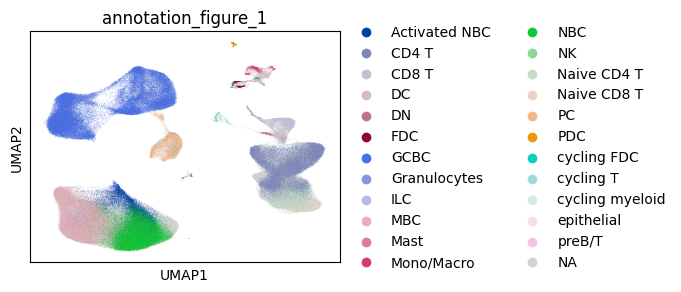

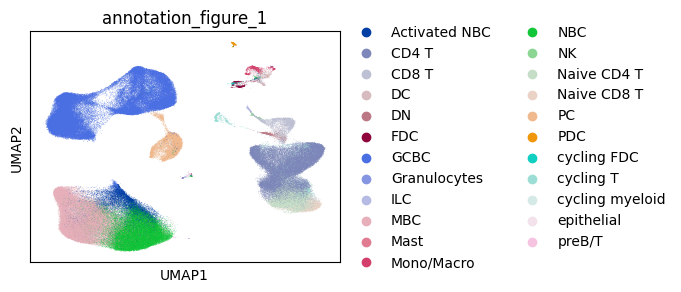

In [55]:
sc.pl.umap(adata_reduced, color="annotation_figure_1")
sc.pl.umap(adata_reduced_discovery, color="annotation_figure_1")

In [48]:
# sc.pl.umap(adata_reduced_discovery)

In [49]:
# sc.pl.umap(adata_reduced_discovery)

In [51]:
# adata.obsm["X_umap"] = adata.obsm["UMAP"].copy()

In [50]:
# sc.pl.umap(adata)